# Custom Estimators

Scikit-learn provides dozens of machine learning models and transformers. However, our workflow sometimes requires us to specify the models or transformations; and such models or transformations should have the `fit`, and either `predict` or `transform` methods that are in compliance with scikit-learn so that we can leverage its functionalities such as Pipeline, GridSearchCV classes and such other features.

In other words, we can define our own `class` of the ML algorithm, and then be piped into the `pipe` of `sklearn`.

This is achieved with custom estimators. Scikit-learn has a base class called `BaseEstimator` that all estimators **inherit** and these models inherit additional classes such as `RegressorMixin`, `ClassifierMixin`, and `TransformerMixin`. We can thus customize our models by inheriting these classes that are in compliance with scikit-learn.

Transformers are estimators which implement a `transform` method. 
Regressors are estimators that implement a predict method while classifiers implement `predict` method in addition to the probability output of the predictions using the `predict_proba` method. For this exercise, we will limit our discussion to transformers.

In [10]:
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin

We will now specify the percentiles for the lower and upper bound and define our fit method that calculates values required to transform the outlier values.

Here below is an example of creating an winsorisation tranformer.

In [5]:
# Create custom transformer class 
# , by inheriting base and additional classes
class OutlierTransform(BaseEstimator, TransformerMixin):

    def __init__(self, q_lower, q_upper):
        self.q_lower = q_lower 
        self.q_upper = q_upper

    def fit(self, X, y=None):
        self.lower = np.percentile(X, self.q_lower, axis=0) 
        self.upper = np.percentile(X, self.q_upper, axis=0)
        return self 
    
    def transform(self, X):
        Xt = X.copy() 
        idx_lower = X < self.lower 
        idx_upper = X > self.upper
        # winsorise, make values less or greater than that given percentile value equal to the percentile value
        for i in range(X.shape[1]):
            Xt[idx_lower[:,i], i] = self.lower[i]
            Xt[idx_upper[:,i], i] = self.upper[i]

        return Xt

Fit method always returns self, which is a copy of the fitted estimator. If self is not returned, this will not be fully compatibale with scikit-learn and will not work with the pipelines.

In [6]:
import yfinance as yf

spx = yf.download('^GSPC',start='2015-01-01')

# Calculate returns and add it to existing DataFrame as a column 
rdict = {str(i)+'D_RET': 
         spx['Adj Close'].pct_change(i) for i in [1,5,20,60,120]}

# Convert to dataframe 
rdf = pd.DataFrame(rdict).dropna()

# Check the output 
rdf.head(2)

[*********************100%%**********************]  1 of 1 completed


,1D_RET,5D_RET,20D_RET,60D_RET,120D_RET
Date,,,,,
2015-06-25,-0.002974,-0.008924,-0.008714,0.016645,0.021431
2015-06-26,-0.000390,-0.004028,-0.002800,0.020294,0.040043


In [7]:
# Convert to numpy array 
Xnew = rdf.values 
Xnew

array([[-2.97357430e-03, -8.92399338e-03, -8.71372466e-03,
         1.66450671e-02,  2.14314005e-02],
       [-3.90079644e-04, -4.02845513e-03, -2.79962543e-03,
         2.02943404e-02,  4.00429757e-02],
       [-2.08661939e-02, -3.07182335e-02, -2.56141118e-02,
        -4.50907058e-03,  2.74790936e-02],
       ...,
       [ 1.34342982e-03,  3.01865793e-02, -4.26302187e-03,
         3.20475104e-02,  1.75935992e-01],
       [-5.83561817e-06,  3.37318902e-02,  5.23768068e-03,
         3.30217775e-02,  1.53918121e-01],
       [ 5.09094770e-03,  2.95959632e-02,  2.88898750e-03,
         5.26753898e-02,  1.57943408e-01]])

In [8]:
# Descriptive Statistics 
rdf.describe()

,1D_RET,5D_RET,20D_RET,60D_RET,120D_RET
count,2234.000000,2234.000000,2234.000000,2234.000000,2234.000000
mean,0.000473,0.002285,0.008998,0.026673,0.051331
std,0.011575,0.023528,0.045395,0.069961,0.090596
min,-0.119841,-0.179666,-0.309439,-0.305884,-0.248372
25%,-0.003773,-0.007325,-0.010798,-0.007555,-0.005627
50%,0.000606,0.004119,0.015222,0.036062,0.054079
75%,0.005860,0.014651,0.034453,0.068924,0.108265
max,0.093828,0.173974,0.224841,0.391566,0.493238


In [11]:
# create, fit and transform for 5 and 95 percentile 
data_transform = OutlierTransform(5,95) 
data_transform.fit(Xnew)

OutlierTransform(q_lower=5, q_upper=95)

In [12]:
Xt = data_transform.transform(Xnew) 
Xt

array([[-2.97357430e-03, -8.92399338e-03, -8.71372466e-03,
         1.66450671e-02,  2.14314005e-02],
       [-3.90079644e-04, -4.02845513e-03, -2.79962543e-03,
         2.02943404e-02,  4.00429757e-02],
       [-1.72941431e-02, -3.07182335e-02, -2.56141118e-02,
        -4.50907058e-03,  2.74790936e-02],
       ...,
       [ 1.34342982e-03,  3.01865793e-02, -4.26302187e-03,
         3.20475104e-02,  1.75935992e-01],
       [-5.83561817e-06,  3.37318902e-02,  5.23768068e-03,
         3.30217775e-02,  1.53918121e-01],
       [ 5.09094770e-03,  2.95959632e-02,  2.88898750e-03,
         5.26753898e-02,  1.57943408e-01]])

In [13]:
# Transformed Data 
pd.DataFrame(Xt).describe()

,0,1,2,3,4
count,2234.000000,2234.000000,2234.000000,2234.000000,2234.000000
mean,0.000568,0.002656,0.009779,0.027431,0.051380
std,0.008385,0.018210,0.035690,0.058461,0.079275
min,-0.017294,-0.037332,-0.066871,-0.096127,-0.102622
25%,-0.003773,-0.007325,-0.010798,-0.007555,-0.005627
50%,0.000606,0.004119,0.015222,0.036062,0.054079
75%,0.005860,0.014651,0.034453,0.068924,0.108265
max,0.016076,0.035479,0.067423,0.118546,0.186551


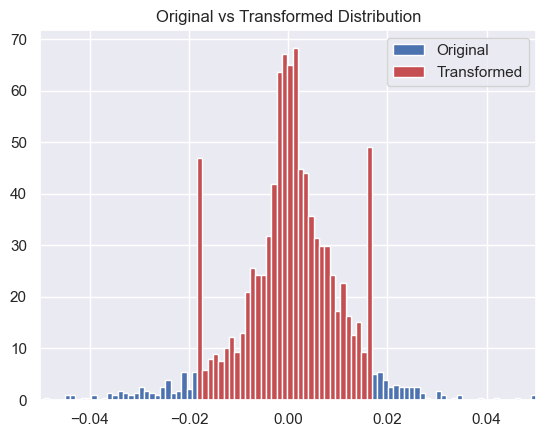

In [16]:
# Import matplotlib for visualization
import matplotlib
import matplotlib.pyplot as plt
# Plot settings
import seaborn as sns
sns.set()

# Plot historgram of 1day returns
_, bins, _ = plt.hist(Xnew[:, 0], density=True, bins=200, alpha=1, color="b", label = "Original")
plt.hist(Xt[:,0], density=True, bins=bins, alpha=1, color='r', label = "Transformed")
# Set title
plt.title("Original vs Transformed Distribution")
# Set x and y axis limits
plt.xlim(-0.05, 0.05)
# Set legends
plt.legend()

## References

* Scikit-learn features selection
* SHAP documentation
* Scikit-learn classes reference
* Python resources